<div style="text-align: right">
    <i>
        LIN 165<br>
        Spring 2025 <br>
        
    </i>
</div>

**Note.** *This notebook is both a walkthrough introduction to Pynini, and an homework. The Homework component has 5 mandatory exercises spread through the notebook, and one optional extra credit question.*

# Finite State Automata/Transducers with Pynini

## Preliminaries
Today we will use the [Pynini Python package](https://github.com/kylebgorman/pynini) for working with finite state transducers (Gorman 2016, Gorman & Sproat 2021).



In [60]:
# Check what version of Python we are running (the Pynini needs at least Python 3.6)
import sys
print(sys.version)

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


In [61]:
# You don't have to --- and shouldn't have to ---do this at home.
! pip install pynini

In [62]:
# You may want to do this once.
! pip install wurlitzer

In [63]:
# This is just a trick to make terminal error messages show up in the notebook.
# You don't need to use it unless you're using a notebook too.
# It won't work unless you've already installed wurlitzer as in the previous
# cell.
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [64]:
import pynini as pn

# the rewrite library is gonna be handy
from pynini.lib import rewrite

## Implementing FSAs with Pynini
OK! We are finally set up and we can get started!
Let's first try creating some finite state acceptors. We need a bit of syntax.

A single acceptor transition can be created using the `pynini.accep()` function.


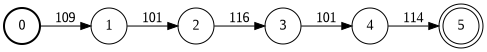

In [65]:
pn.accep("meter")

So what is happening here? Pynini's `accep` function "compiles" a string into a _string FSA_, an acyclic acceptor with:

* start state `0`, and
* a single final state,
* a single arc leaving each non-final state.

What about the arcs? Arc labels are always positive integers; with `0` reserved for the empty string $\epsilon$. By default, the string is "parsed" in `"byte"` mode, with each arc corresponding to a byte in the input string.

Each arc has a numerical label. For instance, the first arc is labeled `109` because the character `'m'` is ASCII character 109, and so on.

In [66]:
# The built-in function `ord` maps from characters to their codepoints.
[ord(ch) for ch in "meter"]

[109, 101, 116, 101, 114]

The `accep` function creates an FSA object of type `Fst`. It is often possible to implicitly cast a string to a bytestring acceptor by passing it where Pynini expects a `Fst` object (as is sometimes done below), though many prefer do this casting explicitly.

Alternatively, one can specify that the string is to be parsed in UTF-8 mode (keyword argument: `token_type="utf8"`), in which arc labels correspond to a Unicode codepoint instead of bytes. This won't have any effect on a string like _meter_, since it is pure ASCII, but it will on the German word _Mütter_ 'mothers' or the Russian word _утка_ 'duck'. Some snippets are given below.

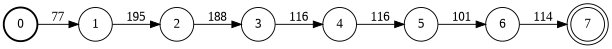

In [67]:
# token_type="byte" is the default; here we specify it explicitly.
# Labels 195 and 188 spell out the codepoint 'ü'.
pn.accep("Mütter", token_type="byte")

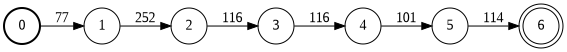

In [68]:
# Here the label 252 corresponds to 'ü'.
pn.accep("Mütter", token_type="utf8")

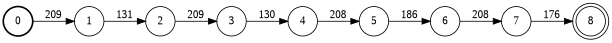

In [69]:
# Here we need two arcs for each Cyrillic character since Cyrillic characters
# are two bytes in UTF-8.
pn.accep("утка", token_type="byte")

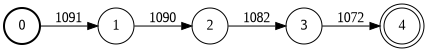

In [70]:
# Here we use just one arc per character since the labels are Unicode codepoints
# rather than bytes.
pn.accep("утка", token_type="utf8")

Finally, one can provide a Pynini symbol table (a mapping between strings and positive integers, which will be used to compile the string into an FSA. In symbol table parsing mode, there must be a single space between each symbol.

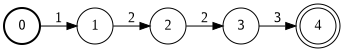

In [71]:
sym = pn.SymbolTable()
sym.add_symbol("<epsilon>")  # The first symbol is always epsilon.
sym.add_symbol("a")
sym.add_symbol("b")
sym.add_symbol("c")
sym.add_symbol("d")
pn.accep("a b b c", token_type=sym)

Be carefull! While we used characters rather than integers in the lecture, this is purely a display convention; the underlying arc labels are *always* integers, even if we as humans choose to interpret them as something else, like bytes, Unicode codepoints, or indices in a large table of symbols. For more details on string compilation (and Unicode in general), see Gorman & Sproat 2021, &#167;2.3 or read the in-module documentation for `accep` (e.g., run `help(pynini.accep)` or `?pynini.accep`).

## Operations

One can perform a number of operations on `Fst` objects.

For example, a repeated state can be specified using `closure()`. Just `closure(fst)` means "repeat zero or more times", `closure(fst, n)` means "repeat at least n times, and `closure(fst, m, n)` means "repeat m to n times".

Let's create a FSA for the regular expression `a*bbc+`:

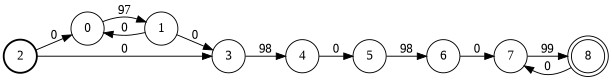

In [72]:
pn.closure(pn.accep("a")) + pn.accep("b") + pn.accep("b") + pn.closure(pn.accep("c"),1)

### **Exercise 1. (5 points)** Thinking back to the formal properties of FSAs, can you figure out why pynini adds all these epsilon transitions? Why are loops represented the way they are?


**Add your answer here**
pynini adds the epsilon transitions for the case of having to combine multiple FSA's together. The epsilon transitions help align outputs with inputs to another FSA. Loops are represented that way to ensure infinite or redundant paths do not occur.

The FSA that is created as a result of many atomic FSA operations is not optimal: it has more transisions and states than needed. The `optimize()` function makes it optimal, and easier to understand:

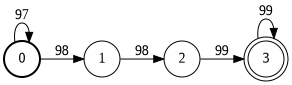

In [73]:
fsa1 = pn.optimize(pn.closure(pn.accep("a")) + pn.accep("b") + pn.accep("b") + pn.closure(pn.accep("c"), 1))
fsa1

Let's now test what kind of strings does this FSA accept. Use the pynini `matches()` function for this:

In [74]:
test = "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabbca"
rewrite.matches(test,fsa1,test)

#Note! A good way to use these checks is as assertion tests for your code!
#assert rewrite.matches(test,fsa1,test)


False

In [75]:
rewrite.matches("abbc", fsa1, "abbc")

True

In [76]:
rewrite.matches("aac",fsa1, "aac")

False

In [77]:
rewrite.matches("aaac", fsa1, "aaac")

False

**Question** Why do we need 3 arguments? Can you figure out why the test string is repeated? Hint: Recall that in Pynini, every FSA is actually and FST imlementing an identity function.

**Answer**: (I would not have figured this out without the Hint) The reason we need 3 arguments is the first is the input, the second is the FSA/disguised FST that we want to run our input on, and the third is the expected output to be produced by the disguised FST. The test string is repeated because we expect our input to shoot out itself (a FST with an identity function)

## Accessing documentation

All Pynini functions, classes, and methods have in-module documentation which can be accessed using `help`. This can help when we cannot figure out the format for a specific function (e.g. if you have no idea what is happening to `matches` above).

In [78]:
help(rewrite.matches)

Help on function matches in module pynini.lib.rewrite:

matches(istring: 'typing.Union[Fst, str]', ostring: 'typing.Union[Fst, str]', rule: _pynini.Fst, input_token_type: Optional[ForwardRef('Union[SymbolTableView, Literal["byte", "utf8"]]')] = None, output_token_type: Optional[ForwardRef('Union[SymbolTableView, Literal["byte", "utf8"]]')] = None) -> bool
    Returns whether an input-output pair is generated by a rule.
    
    Args:
      istring: Input string or FST.
      ostring: Output string or FST.
      rule: Rule FST.
      input_token_type: Optional input token type, or symbol table.
      output_token_type: Optional output token type, or symbol table.
    
    Returns:
      Whether the input-output pair is generated by the rule.



The sequence `p.accep("b") + p.accep("b")` can be also written using `p.accep("bb")`:

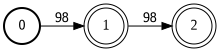

In [79]:
pn.union(pn.accep("b"),pn.accep("b") + pn.accep("b")).optimize()

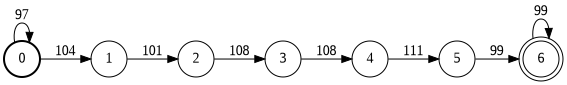

In [80]:
fsa1 = pn.optimize(pn.closure(pn.accep("a")) + pn.accep("hello") + pn.closure(pn.accep("c"), 1))
fsa1

More about the closure() method:

The following are the equivalents for the closure-style syntax used in
Perl-style regular expressions:

    Regexp:             This method:            Copy shortcuts:

    /x?/                x.closure(0, 1)         x.ques
    /x*/                x.closure()             x.star
    /x+/                x.closure(1)            x.plus
    /x{N}/              x.closure(N, N)
    /x{M,N}/            x.closure(M, N)
    /x{N,}/             x.closure(N)
    /x{,N}/             x.closure(0, N)

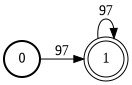

In [81]:
pn.optimize((pn.accep("a").plus))

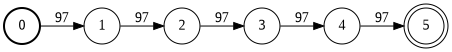

In [82]:
pn.optimize(pn.accep("a").closure(5,5))

In [83]:
help(pn.closure)

Help on cython_function_or_method in module _pynini:

closure(self, lower=0, upper=0)
    closure(self, lower)
    closure(self, lower, upper)
    
    Computes concatenative closure.
    
    This operation destructively converts the FST to its concatenative closure.
    If A transduces string x to y with weight w, then the zero-argument form
    `A.closure()` mutates A so that it transduces between empty strings with
    weight 1, transduces string x to y with weight w, transduces xx to yy with
    weight w \otimes w, string xxx to yyy with weight w \otimes w \otimes w
    (and so on).
    
    When called with two optional positive integer arguments, these act as
    lower and upper bounds, respectively, for the number of cycles through the
    original FST that the mutated FST permits. Therefore, `A.closure(0, 1)`
    mutates A so that it permits 0 or 1 cycles; i.e., the mutated A transduces
    between empty strings or transduces x to y.
    
    When called with one optional posi

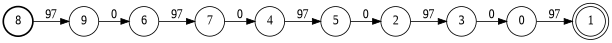

In [84]:
pn.accep("a").closure(5,5)

Let's try with another FSA for a real world example. This will be and FSA that can accept US money amounts, e.g. `one dollar`, `one dollar fifty cents`, etc.

Let's start from a one that recognizes simpler dollar expressions, like "two dollars".

First, we have to define a FSA that accepts digits: "one", or "two", etc. We'll use the pynini `union()`  for creating the set of alternative digits.

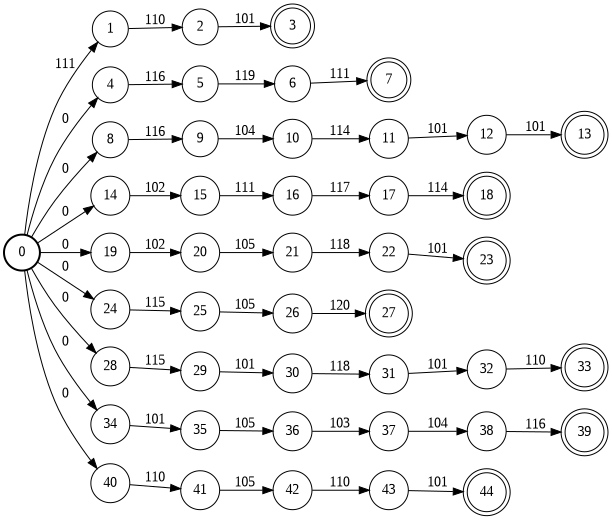

In [85]:
a_1_to_9 = pn.union("one", "two", "three", "four", "five", "six", "seven", "eight", "nine")
a_1_to_9

As you see, more complex FSAs quickly become quite difficult to understand based on their graphic representation.
Optimizing it doesn't really help:

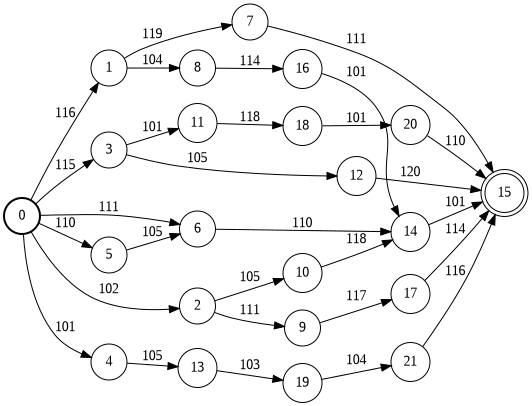

In [86]:
a_1_to_9.optimize()

Let's do a quick check what this FSA accepts:

In [87]:
rewrite.matches("one", a_1_to_9, "one")

True

In [88]:
rewrite.matches("foo",a_1_to_9, "foo")

False

OK, let's try to add dollars and cents:

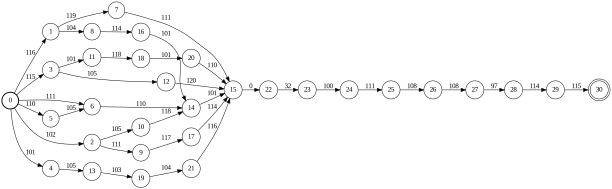

In [89]:
a_1_to_9_dollars = (a_1_to_9 + " dollars")
a_1_to_9_dollars

In [90]:
rewrite.matches("two dollars", a_1_to_9_dollars, "two dollars")

True

Of course it's not really optimal, as it also accepts "one dollars", instead of "one dollar". Let's fix it:

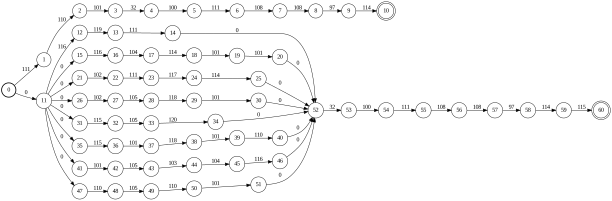

In [91]:
a_2_to_9 = pn.union("two", "three", "four", "five", "six", "seven", "eight", "nine")
dollars = pn.union("one dollar", a_2_to_9 + " dollars")
dollars

In [92]:
rewrite.matches("one dollar", dollars, "one dollar")

True

In [93]:
rewrite.matches("one dollars", dollars, "one dollars")

False

In [94]:
rewrite.matches("two dollars", dollars, "two dollars")

True

In [95]:
rewrite.matches("two dollar", dollars, "two dollar")

False

But the money amount can also have cents. It can actually consist of only cents, like "two cents". Or only from dollars, or from both, like "one dollar two cents". But it shouldn't be empty.

In [96]:
cents = pn.union("one cent", a_2_to_9 + " cents")

In [97]:
money = pn.union(dollars, cents, dollars + " " + cents)

In [98]:
rewrite.matches( "two cents", money, "two cents")

True

In [99]:
rewrite.matches("two dollars one cent", money, "two dollars one cent")

True

In [100]:
rewrite.matches("", money, "")

False

The resulting FSA is already now quite complex:

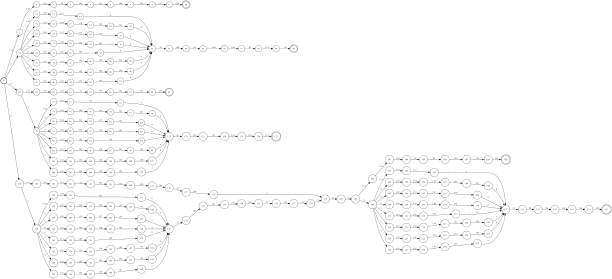

In [101]:
money

Actually, it's complex because it deals with characters, not words. We can simplify it a bit if we make the transitions accept whole tokens, instead of characters. Pynini allows it if you put the tokens in square brackets:

In [102]:
a_2_to_9_words = pn.union("[two]", "[three]", "[four]", "[five]", "[six]", "[seven]", "[eight]", "[nine]")
dollars_words = pn.union("[one][dollar]", a_2_to_9_words + "[dollars]")
cents_words = pn.union("[one][cent]", a_2_to_9_words + "[cents]")
money_words = pn.union(dollars_words, cents_words, dollars_words + cents_words).optimize()


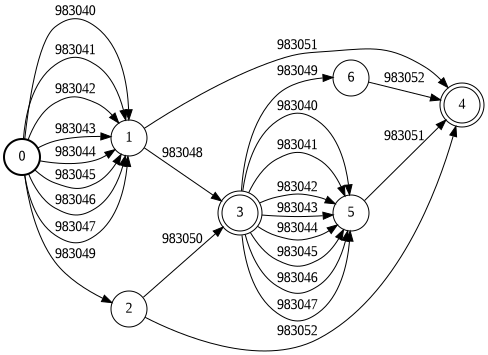

In [103]:
money_words

The above picture looks already much nicer! Note that the test string must then also be tokenized, with tokens surrounded by square brackets:

In [104]:
rewrite.matches("[one][dollar]", money_words, "[one][dollar]")

True

One way to debug FSAs is to  generate random output, by selecting random paths from it's start state until the end state:

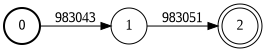

In [105]:
pn.randgen(money_words)

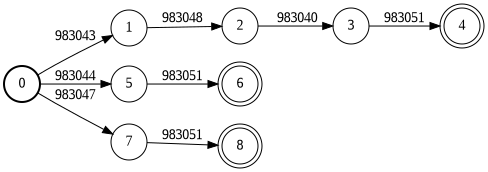

In [106]:
pn.randgen(money_words, 3)

### **Exercise 2. (2 points)**

Make the money FSA accept more complex amounts, like "twenty one dollars thirteen cents"


In [107]:
# Add your code here
a_2_to_9_words = pn.union("[two]", "[three]", "[four]", "[five]", "[six]", "[seven]", "[eight]", "[nine]")
a_10_to_19 = pn.union("[ten]", "[eleven]", "[twelve]", "[thirteen]", "[fourteen]", "[fifteen]", "[sixteen]", "[seventeen]", "[eighteen]", "[nineteen]")
a_20_to_90 = pn.union("[twenty]", "[thirty]", "[forty]", "[fifty]", "[sixty]", "[seventy]", "[eighty]", "[ninety]")
dollars_words = pn.union(a_10_to_19, a_20_to_90 + "[one][dollar]", a_2_to_9_words + "[dollars]")
tens_words = pn.union(a_10_to_19, a_20_to_90 + " " + a_2_to_9_words)
cents_words = pn.union("[one][cent]", a_2_to_9_words + "[cents]")
money_words = pn.union(dollars_words, cents_words, dollars_words + cents_words).optimize()

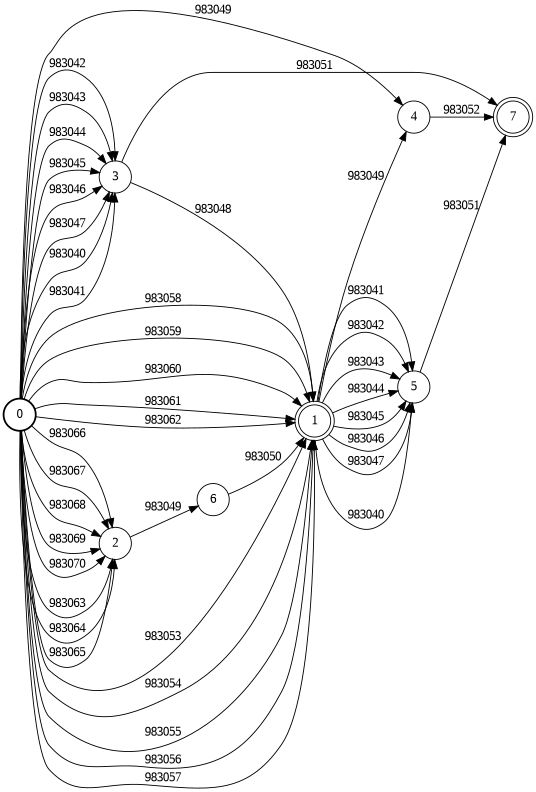

In [108]:
money_words

In [109]:
#testing
rewrite.matches("[twenty][one][dollar]", money_words, "[twenty][one][dollar]")

True

### **Exercise 3. (3 points)**

Construct a FSA that accepts English numbers from 0 to 99, given as words, e.g. `[twenty] [one]`. Try to be economical, don't just list all possible 100 variants

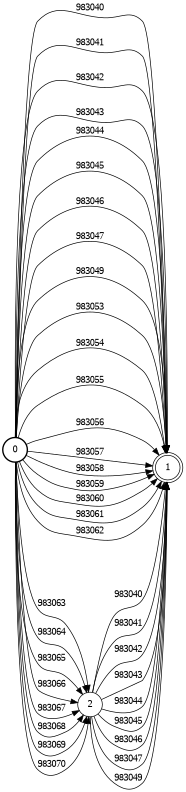

In [110]:
# Add your code here
a_1_to_9_words = pn.union("[one]", "[two]", "[three]", "[four]", "[five]", "[six]", "[seven]", "[eight]", "[nine]")
a_10_to_19 = pn.union("[ten]", "[eleven]", "[twelve]", "[thirteen]", "[fourteen]", "[fifteen]", "[sixteen]", "[seventeen]", "[eighteen]", "[nineteen]")
a_20_to_90 = pn.union("[twenty]", "[thirty]", "[forty]", "[fifty]", "[sixty]", "[seventy]", "[eighty]", "[ninety]")
numbers_words = pn.union(a_1_to_9_words, a_10_to_19, a_20_to_90 + a_1_to_9_words).optimize()

numbers_words


Let's now try to construct a naive FSA that accepts a very limited set of English nouns, like dog, cat, mouse, dogs, mice sheep, etc.

In [111]:
reg_noun = pn.union("dog", "cat", "wombat", "dragon")
irreg_noun_sg = pn.union("mouse", "sheep")
irreg_noun_pl = pn.union("mice", "sheep")
nouns = pn.union(reg_noun, reg_noun + "s", irreg_noun_sg, irreg_noun_pl).optimize()


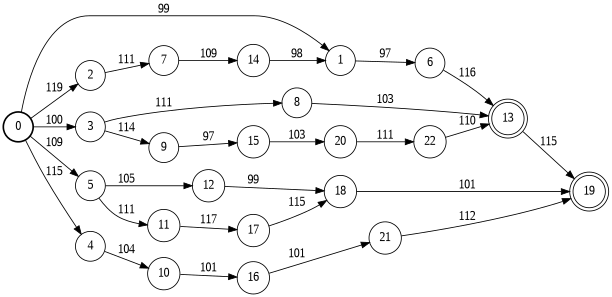

In [112]:
nouns

In [113]:
rewrite.matches("dogs", nouns, "dogs")

True

In [114]:
rewrite.matches("mouses", nouns, "mouses")

False

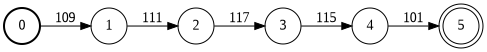

In [115]:
pn.randgen(nouns)

In [116]:
help(pn.randgen)

Help on cython_function_or_method in module _pywrapfst:

randgen(ifst, npath=1, select='uniform', max_length=2147483647, weighted=False, remove_total_weight=False, seed=18446744073709551615)
    randgen(ifst, npath=1, seed=0, select="uniform", max_length=2147483647,
            weighted=False, remove_total_weight=False, seed=-1)
    
    Randomly generate successful paths in an FST.
    
    This operation randomly generates a set of successful paths in the input FST.
    This relies on a mechanism for selecting arcs, specified using the `select`
    argument. The default selector, "uniform", randomly selects a transition
    using a uniform distribution. The "log_prob" selector randomly selects a
    transition w.r.t. the weights treated as negative log probabilities after
    normalizing for the total weight leaving the state. In all cases, finality is
    treated as a transition to a super-final state.
    
    Args:
      ifst: The input FST.
      npath: The number of random paths

## String Extraction

Ok, all good with integers, but this makes it very hard to debug the FSAs no? Well, if an FSA has exactly one complete path, then we can convert it into a Python string using the `string` method. Like `accep`, this method takes a `token_type` argument, and like `accep`, the default value is `"byte"`.

In [117]:
pn.randgen(nouns).string()

'mouse'

Note that `string()` WILL raise an exception if there is more than one path!

**NOTE**: this means that this fsa is non-deterministic

In [118]:
# FAIL; raises FstOpError.
nouns.string()

ERROR: StringFstToOutputLabels: State 1 has multiple outgoing arcs


FstOpError: Operation failed

If an FSA is acyclic, one can use the `paths` method to enumerate all strings.
The order in which these are listed is implementation-defined (i.e., essentially arbitrary).

In [120]:
list(nouns.paths().ostrings())

['cat',
 'cats',
 'dog',
 'dogs',
 'dragon',
 'dragons',
 'mice',
 'mouse',
 'sheep',
 'wombat',
 'wombats']

**Question** Why is it crucial for the FSA to be Acyclic for the operation above to work? Click below for the answer!

<details>

<summary>Answer</summary>

If an FSA is cyclic, it has an infinite number of paths, and there is no way to enumerate all strings it matches. Calling `paths` on a cyclic FSA will raise an exception.
</details>



### **Exercise 4. (5 points)**
Create a FSA that accepts Estonian nouns with at least 3 words and 3 inflections.
The words are:
  -  *karu, laud, vahvel*

The inflections are:
-  nimetav (e.g., karu - laud - vahvel)
- omastav (e.g., karu - laua - vahvli)
- kaasaütlev (e.g., karuga - lauaga - vahvliga).

Try to reuse parts of omastav when constructing kaasaütlev, instead of just listing all nine varints of the words. That is, it should be easy to extend this FSA to understand new inflections.

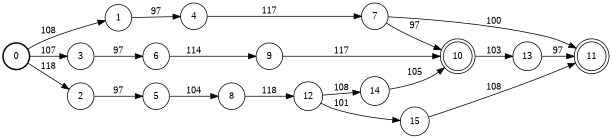

In [121]:
# Add your code here
reg_noun = pn.union("karu", "laud", "vahvel")
nimetav = pn.union("karu", "laud", "vahvel")
omastav = pn.union("karu", "laua", "vahvli")
kaasaütlev = pn.accep("ga")

language = pn.union(reg_noun, nimetav, omastav, omastav + kaasaütlev).optimize()
language

In [122]:
rewrite.matches("karu", language, "karu")

True

In [123]:
rewrite.matches("laua", language, "laua")

True

In [124]:
rewrite.matches("lauaga", language, "lauaga")

True

### **Exercise 5 (5 points).**


Many languages have phonological processes called
“harmony”. For example, in Bukusu co-occurring liquids [l, r] must agree
independently on their distance (so you can either have sequences of [l] or
sequences of [r], but not both).

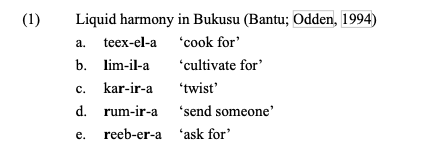

Write an FSA that checks that a word in input respects liquid harmony. You
can assume Latin alphabet as input instead of having to rely on IPA (as a
realistic system would have to do). Use the data in as a test that your FSA
accepts the correct strings (ignore the - symbols, which are there to highlight morphological components of the words). Your FSA should work for ANY word, not just for the words in (1).
Also provide a couple of examples that violate the harmony rule, and test that your FSA correctly rules them out (i.e. does not accept them).
[Hint. Vowels, and any consonant that is not a liquid, do not really matter for the harmony rule the automaton is verifying]



In [125]:
# Add your code here ignore this, my process of trying to find a "any" character
# epsTest = pn.accep("<epsilon>").closure()
# epsTest.optimize(True)

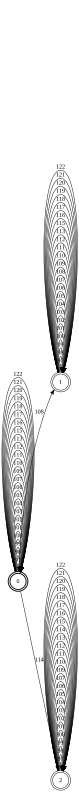

In [126]:
notLorR = pn.union("a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "m", "n", "o", "p", "q", "s", "t", "u", "v", "w", "x", "y", "z")
state0 = notLorR.closure()
state1 = pn.union("l", notLorR).closure()
state2 = pn.union("r", notLorR).closure()
harmony_machine = pn.union(state0 + pn.union(state1, state2))
harmony_machine.optimize(True)

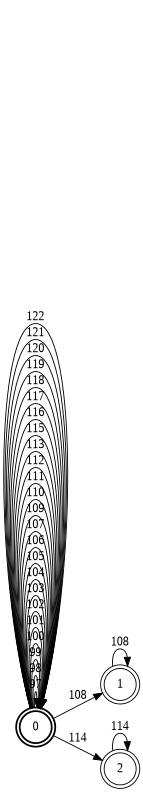

In [127]:
state1_test= pn.accep("l").closure()
state2_test = pn.accep("r").closure()
harmony_machine_test = pn.union(state0 + pn.union(state1_test, state2_test))
harmony_machine_test.optimize(True)

In [128]:
# TESTS # teexela limila karira rumira reebera
rewrite.matches("teexela", harmony_machine, "teexela")

True

In [129]:
rewrite.matches("limila", harmony_machine, "limila")

True

In [130]:
rewrite.matches("karira", harmony_machine, "karira")

True

In [131]:
rewrite.matches("rumira", harmony_machine, "rumira")

True

In [132]:
rewrite.matches("reeber", harmony_machine, "reeber")

True

In [133]:
print(rewrite.matches("ramanili", harmony_machine, "ramanili"))
print(rewrite.matches("lameboybarororo", harmony_machine, "lameboybarororo"))

False
False


## Implementing FSTs with Pynini

So far in this notebook we looked at acceptors. If your recall (if you don't go back to the slides!), transducers are like acceptors, but every arc has input and output symbols, instead of just input symbols. Note that by default, output symbols are equal to input symbols. So, actually every FSA is also an FST in Pynini.

A transducer arc is constucted using Pynini's `cross` function. It takes two arguments: input and output strings.


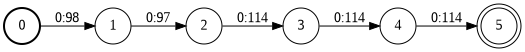

In [134]:
pn.cross("", "barrr")

In [135]:
help(pn.cross)

Help on cython_function_or_method in module _pynini:

cross(fst1, fst2)
    cross(fst1, fst2)
    
    Creates a cross-product transducer.
    
    This function creates an FST which transduces from the upper language
    to the lower language.
    
    Args:
      fst1: The input string, or an acceptor FST representing the upper
          language.
      fst2: The output string, or an acceptor FST representing the upper
          language.
    
    Returns:
      An FST.
    
    Raises:
      FstOpError: Operation failed.



**Question** Why is the transducer function called `cross`?

<details>

<summary>Answer</summary>
The cross function creates a transducer from two FSTs, compiling string arguments into FSTs if necessary. The result is a cross-product of the two input FSTs, interpreted as acceptors. Specifically, the transducer is constructed by mapping output arcs in the first FST to epsilon, mapping the input arcs in the second FST to epsilon, then concatenating the two. In the case that both FSTs are strings, the resulting transducer will simply contain the input and output string converted into labels, and the shorter of the two will be padded with epsilons.
</details>


Let's  construct a FST that accepts a string "aabdd" and changes it into "aacdd". Recall that acceptors in Pynini are FSTs that do identity!

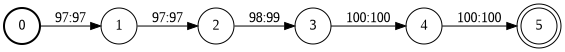

In [136]:
fst0 = (pn.accep("aa") + pn.cross("b", "c") + pn.accep("dd")).optimize()
fst0

In [137]:
# Let's test it
# Are you ok with @?

x = "aabdd" @ fst0
x.string()

'aacdd'

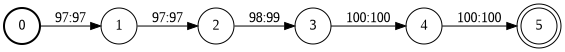

In [138]:
"aabdd" @ fst0


Let's look at something more complicated. What mapping does the following FST recognize?

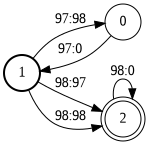

In [139]:
fst1 = (pn.cross("aa", "b").closure() + pn.union(pn.cross("b", "a"), pn.accep("b")) + pn.cross("b", "").closure()).optimize()
fst1

If you look carefully, you will see that the result of composing a string "b" (98) with the FST is actually ambiguous: there are two paths, one resulting in output "a" and the other one in "b". This is because the FST is non-deterministic: it has to arcs from state 1 to state 2, both with input "b". The ambiguous result is conveniently represented as an FST BUT it will create problems for .string()!

To get the possible outputs as strings, use the paths() method of the resulting FST, and the `ostrings()` method or the resulting path iterator:

In [140]:
list(("b" @ fst1).paths().ostrings())

['a', 'b']

In [141]:
("b" @ fst1).paths().ostrings()

In [142]:
def all_paths(fst):
    return list(fst.paths().ostrings())

all_paths("aaaaaabb" @ fst1)

['bbba', 'bbbb']

Let's play some more with this FST:

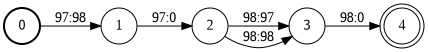

In [143]:
("aabb" @ fst1)

In [144]:
all_paths("aabb" @ fst1)

['ba', 'bb']

One thing that we did not discuss in the lecture, is the fact that any FST can be inverted: The inversion of a transducer switches the input and output labels.
Pynini implements inversion directly:

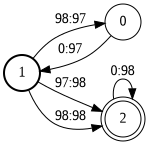

In [145]:
fst1_invert = pn.invert(fst1)
fst1_invert

The inverse FST should apply the inverse mapping. I.e., if the original FST converts from "b" to "a", then the inverse should convert from "a" to "b". Let's try:

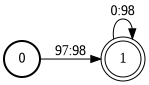

In [149]:
"a" @ fst1_invert

In [150]:
all_paths("a" @ fst1_invert)

ERROR: PathIterator: Cyclic FSTs have an infinite number of paths


FstOpError: Operation failed

Wait! It looks like the inversion worked (the first cell run) but then we get an error trying to get all the possible paths. Why is that?

It is because there is an infinite number of outputs that correspond to input "a": b, bb, bbbbbbbb, etc. (Do you see why? Do you see that arc `<epsilon>:b` from the final state? We can take this arc any number of times).

To address this issue, we can use the `pynini.shortestpath(fst, nshortest=10)` function to select 10 shortest paths from the resulting FST. Note that "shortest" here means shortest in the FST sense, i.e., the paths with the minimum *cost*. Since all our paths have a cost of zero (since we haven't added any weights to them), all paths have the same cost, and `shortestpath()` selects random paths:

In [151]:
list((pn.shortestpath("a" @ fst1_invert, nshortest=10)).paths().ostrings())

['bbbbbbbb',
 'bbbbbbbbb',
 'bbbbbbbbbb',
 'bbbb',
 'bbbbb',
 'bbbbbb',
 'bbb',
 'bb',
 'bbbbbbb',
 'b']

Let's make a new function to actually do that:

In [152]:
def top10_paths(fst):
    return list(pn.shortestpath(fst, nshortest=10).paths().ostrings())

top10_paths("a" @ fst1_invert)

['bbbbbbbb',
 'bbbbbbbbb',
 'bbbbbbbbbb',
 'bbbb',
 'bbbbb',
 'bbbbbb',
 'bbb',
 'bb',
 'bbbbbbb',
 'b']

Ok, now that we know basic Pynini syntax, let's try do do some simple morphological analysis using FSTs.

Let's look at three Estonian words *ratsu, kõne, male*. They all inflect in the same way:
  * Nominative: ratsu, kõne, male
  * Genitive: ratsu, kõne, male
  * Partitive: ratsut, kõnet, malet
  * Illative: ratsusse, kõnesse, malesse
  
We want to define an FST which accepts all the above words in the four inflections, and output the word in Nominative case, with an appended infection marker, e.g.:

 >ratsusse -> ratsu /ill/

 > kõnet -> kõne /p/.

Let's first try to define the stems, and a transducer for nominative inflection:

In [154]:
stems = pn.union("ratsu", "kõne", "male", "karka")
nominative = stems + pn.cross("", " /nom/")

Question: Do you get what the second line does?

In [155]:
#Let's test it!
top10_paths("ratsu" @ nominative)

['ratsu /nom/']

Ok, let's now define transducers for the other infections.

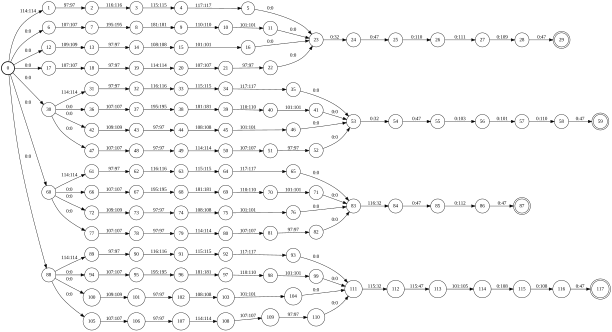

In [156]:
genitive = stems + pn.cross("", " /gen/")
partitive = stems + pn.cross("t", " /p/")
illative = stems + pn.cross("sse", " /ill/")

wordform_to_analysis = pn.union(nominative, genitive, partitive, illative)

wordform_to_analysis

Note how the FST correctly captures the fact that the word `ratsu` has actually two ambiguous analyses: `ratsu` can be either nominative or genitive -- both use the same word form:

In [157]:
top10_paths("ratsu" @ wordform_to_analysis)

['ratsu /nom/', 'ratsu /gen/']

In [158]:
top10_paths("karkasse" @ wordform_to_analysis)[0]

'karka /ill/'

One of the nice things about FSTs is that they can be inverted, as we already learned. But it turns out that this is really useful in the context of morphological analysis. If we invert a FST that does morphological analysis, we get a FST that does morphological generation! Let's try:

In [159]:
analysis_to_wordform = pn.invert(wordform_to_analysis)
top10_paths("karka /ill/" @ analysis_to_wordform)

['karkasse']

Now, we discussed in the lecture that one of the most useful FST operations are context-dependent rewrite operation.

For example, we can define an FST which transforms *b* to *c* ONLY when *b* occurs between *a* and *d*. As we saw in class, this can be formalized as a rewrtite rule of the form:

>  b → c/a___d

An example of the application of this rule would be:

> abbabdc -> abbacdc


If you have taken a phonology class, you might notice that this looks exactly like a phonological rewrite rule! So let's define an FST for it:

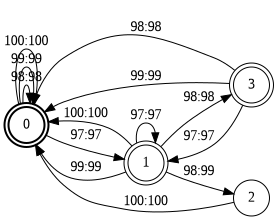

In [160]:
rewrite_fst = pn.cdrewrite(pn.cross("b", "c"), "a", "d",pn.union("a","b","c","d").closure()).optimize()
rewrite_fst

Note that the last argument to cdrewrite, `pn.u(*"abcd").closure()` must be a cyclic, unweighted acceptor representing the closure over the alphabet (what happens if you don't do that?). I.e., it represents all the possible strings that can be input to cdrewrite. Let's check what this FST does:

In [161]:
top10_paths("abd" @ rewrite_fst)

['acd']

In [162]:
top10_paths("abbabdc" @ rewrite_fst)

['abbacdc']

If the left context and right context do not match, it doesn't do anything.

In [163]:
top10_paths("b" @ rewrite_fst)

['b']

We may leave the right (or left) context empty, then this context is not checked:

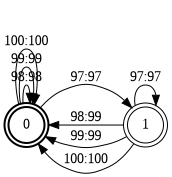

In [164]:
rewrite_fst2 = pn.cdrewrite(pn.cross("b", "c"), "a", "", pn.union("a","b","c","d").closure()).optimize()
rewrite_fst2



Note that the left context and right context do not need to be strings -- they can be any acceptors. For example, let's modify the rewrite FST so that it replaces "b" with "c" if "a" is seen *anywhere* before the "c", not necessarily immidiately before it:

In [165]:
rewrite_fst3 = pn.cdrewrite(pn.cross("b", "c"), "a" + pn.union("a","b","c","d").closure(), "", pn.union("a","b","c","d").closure()).optimize()
top10_paths("ab" @ rewrite_fst3)

['ac']

In [166]:
top10_paths("cccb" @ rewrite_fst3)

['cccb']

In [167]:
top10_paths("accccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccb" @ rewrite_fst3)

['accccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc']

The cdrewrite function is useful for making a morphological analyzer more flexible. Let's try to make an analyzer for the Estonian words vahvel, noobel, number. They inflect as:

  * Nominative: vahvel, noobel, number
  * Genitive: vahvli, noobli, numbri
  * Partitive: vahvlit, nooblit, numbrit
  * Illative: vahvlisse, nooblisse, numbrisse
  
These words are more complicated then what we saw before, because different inflections are not a result of just adding a suffix to the nominative stem (as with the word "ratsu") -- for example, the stem also changes from "vahvel" to "vahvl".

Let's first make a FST that can inflect all words based on the ending, where the ending is seperated by "^":

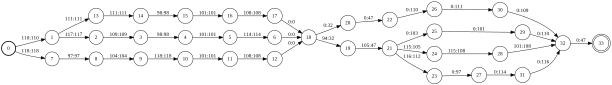

In [168]:
words = ["number", "vahvel", "noobel"]
end_analyzer = pn.string_map(words) + pn.union(pn.cross("^it", " /part/"), pn.cross("^isse", " /ill/"), pn.cross("^i", " /gen/"), pn.cross("", " /nom/")).optimize()
end_analyzer

This FST can analyze words where the ending has been properly seperated:

In [169]:
top10_paths("number^i"@ end_analyzer)

['number /gen/']

Now let's create another FST that can transform "numbri" to "number^i" and "vahvli" to "vahvel^i":

In [170]:
sigma_star = pn.union(*"abdefghjiklmnoprstuvõäöüxy^").closure()
stem_change = pn.cdrewrite(pn.union(pn.cross("li", "el^i"), pn.cross("ri", "er^i")), "", pn.union("", "s", "sse", "ga") + "[EOS]", sigma_star).optimize()

top10_paths("numbri"@ stem_change)

['number^i']

The stem change li -> el^i, ri -> er^i is only applied if the left context is "[EOS]", "s[EOS]", "sse[EOS]", etc. Here [EOS] is Pynini's special symbol for the end-of-string. This is needed because we don't want any other occurrences of "li" to be replaced, e.g. "ribambri" should be changed to "ribamber^i", not "er^ibamber^i". Let's check:

In [171]:
top10_paths("ribambri"@ stem_change)

['ribamber^i']

And now, we can put the two FSTs together, by composing them:

In [172]:
wordform_to_analysis2 = stem_change @ end_analyzer

top10_paths("numbri" @ wordform_to_analysis2)

['number /gen/']

Can we invert it, as we did before with the simpler analyzer?

In [173]:
analysis_to_word2 = pn.invert(wordform_to_analysis2)

In [174]:
top10_paths("number /gen/" @ analysis_to_word2)

['number^i', 'numbri']

What happened? Why is 'number^i' also returned as a possible word form? This is because the cdrewrite operation is optional. In fatc,  when we input 'number^i' with our analysis_to_word2, it will happily analyze it (which is of course a problem):

In [175]:
top10_paths("number^i" @ wordform_to_analysis2)

['number /gen/']

In order to fix this, we have to change our FST so that it wouldn't even accept a string containing "^". We can do it by just putting an acceptor before everything, that doesn't accept a string containing "^":

In [176]:
valid_chars = pn.union(*"abdefghjiklmnoprstuvõäöüxy").closure().optimize()
wordform_to_analysis2 = (valid_chars @stem_change @ end_analyzer)
top10_paths("numbri" @ wordform_to_analysis2)

['number /gen/']

In [177]:
top10_paths("number^i" @ wordform_to_analysis2)

[]

In [178]:
analysis_to_word2 = pn.invert(wordform_to_analysis2)
top10_paths("number /gen/" @ analysis_to_word2)

['numbri']

We can now even put our two analyzers together:

In [179]:
composite_wordform_to_analysis = pn.union(wordform_to_analysis, wordform_to_analysis2)

In [180]:
top10_paths("numbri" @ composite_wordform_to_analysis)

['number /gen/']

In [181]:
top10_paths("ratsu" @ composite_wordform_to_analysis)

['ratsu /nom/', 'ratsu /gen/']

As before, we can use random generation to check whether the big FST generates only valid output

In [182]:
for w in (top10_paths(pn.randgen(composite_wordform_to_analysis, 5))): print(w)

male /p/
male /nom/
kõne /p/
male /nom/
karka /gen/


Finally, a remark about the concept of **nothing**. It's important to understand you can transduce "something" from "nothing". For example, you can use the following transducer for put spaces between each character (see how `pn.cross("", " ")` transduces empty string into space):

In [183]:
one_character = pn.union(*"abdefghjiklmnoprstuvõäöüxy")
spacer = (one_character +  pn.cross("", "     ")).closure() + one_character

In [184]:
("skdjhgskjhgksjhdgksjhdksjfksjhfkjshfd" @ spacer).string()

's     k     d     j     h     g     s     k     j     h     g     k     s     j     h     d     g     k     s     j     h     d     k     s     j     f     k     s     j     h     f     k     j     s     h     f     d'

### **Exercise 6 (10 points).**
The previous liquid harmony exercise relied on a check of the
phonotactics of a language (whether a word is well formed or not). But
phonology is often about processes. For instance, the data show how
the morphological suffix between dashes changes from [l] to [r] depending on
which liquid was present in the root of the word. Write an FST for this process of forward assimilation (e.g. sounds in a word change based on the
occurrence of one specific sound before them). You do not need to
distinguish the morphological components: assume that the first liquid encountered (l or r) is the once that forces all the following ones to agree. To test your FSA, you can use the following examples:

A. teexela -> teexela

B. karila -> karira

C. polonuri -> polonuli

As for the FSA though, your FST should work for any word with liquids, not
just for your three examples.

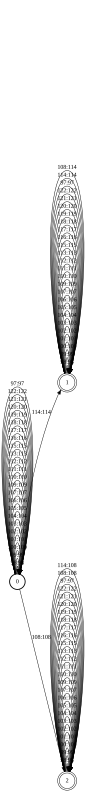

In [185]:
# Add your code here
notLorR = pn.union("a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "m", "n", "o", "p", "q", "s", "t", "u", "v", "w", "x", "y", "z")
state0 = notLorR.closure()
state1 = pn.union("l" + pn.union("l" , pn.cross("r", "l"), notLorR).closure())
state2 = pn.union("r" + pn.union("r" , pn.cross("l", "r"), notLorR).closure())
harmony_machine = pn.union(notLorR + pn.union(state1, state2))
harmony_machine.optimize(True)

In [186]:
# # A. teexela -> teexela

# B. karila -> karira

# C. polonuri -> polonuli
# ("b" @ fst1).paths().ostrings()

list(("teexela" @ harmony_machine).paths().ostrings())

['teexela']

In [187]:
list(("karila" @ harmony_machine).paths().ostrings())

['karira']

In [188]:
list(("polonuri" @ harmony_machine).paths().ostrings())

['polonuli']

In [189]:
list(("lllllllllrlrlrlrlrlrlrlrlrlrlrlr" @ harmony_machine).paths().ostrings())

['llllllllllllllllllllllllllllllll']

In [190]:
list(("rllllllrllllll" @ harmony_machine).paths().ostrings())

['rrrrrrrrrrrrrr']

### **Extra Credit Exercise (Optional, 10 points).**

The lecture slides discuss an example of an FST to handle the English orthographic rule of *e- insertion*. In the slides I also included a table (adapted from Jurawski and Martin) with examples of few other spelling rules for English. Write a transducer that handles either of
- (a) the K insertion rule
- (b) the consonant doubling spelling rule.

You can pick whichever of the two looks more intuitive to you.
Start by providing a formalization of the descriptive rule in terms of rewrite rule (I will not grade the correctness of the rewrite rule, nor I expect your FST to be perfect. Just provide an implementation that handles what you consider general cases. I will use your rule to check what your transducer aims to do, and if it actally does it).

 Also provide some test in terms of expected input-output pairs, and provide code to test your implemetation (as we did for all the FSAs and FSTs above)

**Add your answer here**

- provide your rewrite rule(s) here
- provide some expected input-output pairs here

In [191]:
# Add your code here

In [202]:
V = pn.union(*"aeiou").optimize()
C = pn.union(*"bcdfghjklmnpqrstvwxyz").optimize()
L = pn.union(*"abcdefghijklmnopqrstuvwxyz").optimize()

double_final_consonant = (
    pn.closure(L) + V + pn.cross(C, C + C)
).optimize()


pass_through = pn.difference(pn.closure(L) + pn.accep(""), double_final_consonant).optimize()

doubling_fst = pn.union(double_final_consonant, pass_through).optimize()


ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?) w1 = 122 w2 = 121
ERROR: StringWeight::Plus: Unequal arguments (non-functional FST?

FstOpError: Operation failed

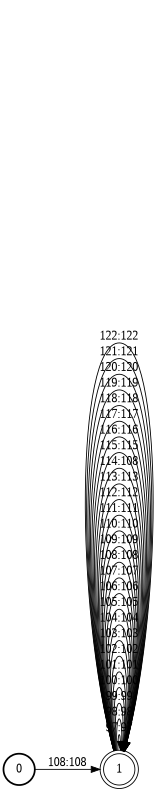

In [192]:
vowels = pn.union(*"aeiou")
consonants = pn.union(*"bcdfghjklmnpqrstvwxyz")

# state0 =
state1and2 = pn.union(pn.union(vowels, consonants) + consonants.closure() + vowels + vowels.closure())
checkb = pn.union(("b" + pn.cross("", "b")))

state1.optimize()

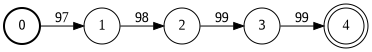

In [193]:
pogtest = pn.union("abc" + pn.accep("c"))
pogtest.optimize()

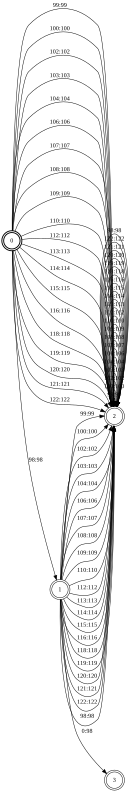

In [194]:
checkb = pn.union(consonants , "b" + pn.cross("", "b"))
checkb.optimize(True)

In [196]:
list(("bed" @ consonant_doubling_machine).paths().ostrings())

NameError: name 'consonant_doubling_machine' is not defined

In [ ]:
vowels = pn.union(*"aeiou")
consonants = pn.union(*"bcdfghjklmnpqrstvwxyz")

machine = pn.union(*"abcdefghijklmnopqrstuvwxyz").closure()

consonant_doubling_machine = (pn.cdrewrite(pn.cross(consonants, consonants + consonants),vowels,pn.accep(""),machine,)).optimize()
consonant_doubling_machine

In [ ]:

test_cases = {
    "hop": "hopp",
    "hug": "hugg",
    "run": "runn",  # should not be correct
    "bat": "batt",
    "bed": "bedd",
    "rob": "robb",
}

# Test the FST
for input_string, expected_output in test_cases.items():
    actual_output = rewrite.top_rewrite(input_string, consonant_doubling_machine)
    print(f"Input: {input_string}, Expected: {expected_output}, Actual: {actual_output}, Result: {expected_output == actual_output}")


## References

Gorman, K. 2016. Pynini: a Python library for weighted finite-state grammar compilation. In _Proceedings of the ACL Workshop on Statistical NLP and Weighted Automata_, pages 75-80.

Gorman, K. and Sproat, R. 2021. _Finite-State Text Processing_. Morgan & Claypool.

Mohri, M. 2002. Generic epsilon-removal and input epsilon-normalization algorithms for weighted transducers. _International Journal of Computer Science_, 13(1):129-143.

Thompson, K. 1968. Programming techniques: regular expression search algorithm. _Communications of the ACM_, 11(6):419-422.